# CTDS Single-Region 

### What this notebook does
1. **Data Generation** - Create synthetic neural data with cell-type constraints
2. **Model Fitting** - Initialize and fit CTDS using EM algorithm  
3. **Accuracy Metrics** - Compute parameter recovery errors and R² scores
4. **Visualization Plots** - EM convergence, heatmaps, trajectory comparisons
5. **Numerical Stability** - Eigenvalue analysis and matrix conditioning  

### Current findings
- EM converges reliably on **well-conditioned synthetic data** (condition number < ~20).  
- One-step predictions are essentially flat vs baseline:  
  - NRMSE ≈ 1.0 (no gain over mean predictor)  
  - R² ≈ 0 or negative across neurons.  
- Suggests that either:  
  - Solver instabilities (jaxopt CDQP in M-step), or  
  - High observation noise / poor conditioning  
  are preventing dynamics from being used effectively.  

### What’s not implemented yet
- ❌ Alignment of recovered parameters (blockwise permutation + scaling).  
- ❌ Solver ablations (LS vs projected LS vs CDQP).  
- ❌ Additional validation metrics (predictive log-likelihood, multi-step forecasts, whitened innovations, imputation).  
- ❌ CPU JIT (GPU JIT works; CPU blocked by XLA layout).  





In [1]:
# Setup and Imports
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from typing import Tuple, Optional
import time
from functools import partial
import seaborn as sns
# Configure JAX for float64 precision
jax.config.update("jax_enable_x64", True)

# Import CTDS modules
from models import CTDS
from params import (
    ParamsCTDS, ParamsCTDSInitial, ParamsCTDSDynamics, 
    ParamsCTDSEmissions, ParamsCTDSConstraints, SufficientStats
)
from inference import DynamaxLGSSMBackend
from simulation_utilis import generate_synthetic_data, generate_CTDS_Params, align_single_region_ctds
# Set random seeds for reproducibility
np.random.seed(42)
key = jr.PRNGKey(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Setup complete!")
print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"JAX backend: {jax.default_backend()}")

✅ Setup complete!
JAX version: 0.4.38
JAX devices: [CpuDevice(id=0)]
JAX backend: cpu


## 1. Define Ground Truth Model Parameters

We'll create a small, stable dynamical system with Dale's law constraints:
- **State dimension**: D = 6 (3 excitatory + 3 inhibitory dimensions)
- **Observation dimension**: N = 20 neurons
- **Cell types**: 2 types (excitatory and inhibitory)
- **Time steps**: T = 200

 STEP 1: GENERATING SYNTHETIC NEURAL DATA
Condition number of A_true: 4.906572570537099
Condition number of C_true: 3.3799634841061237
Condition number of Q_true: 5.238426242675188
Condition number of R_true: 6.706393092485412
Condition number of observations: 3.534626711349381
Model structure:
  State dimension (D): 4
  Observation dimension (N): 20
  Time steps (T): 200
  Cell types: 2
  Cell type mask: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
  Cell type dimensions: [2 2]
  Dynamics mask: [ 1  1 -1 -1]

📊 Dataset Generated:
  • A true shape: (4, 4)
  • C true shape: (20, 4)
  • Q true shape: (4, 4)
  • R true shape: (20, 20)


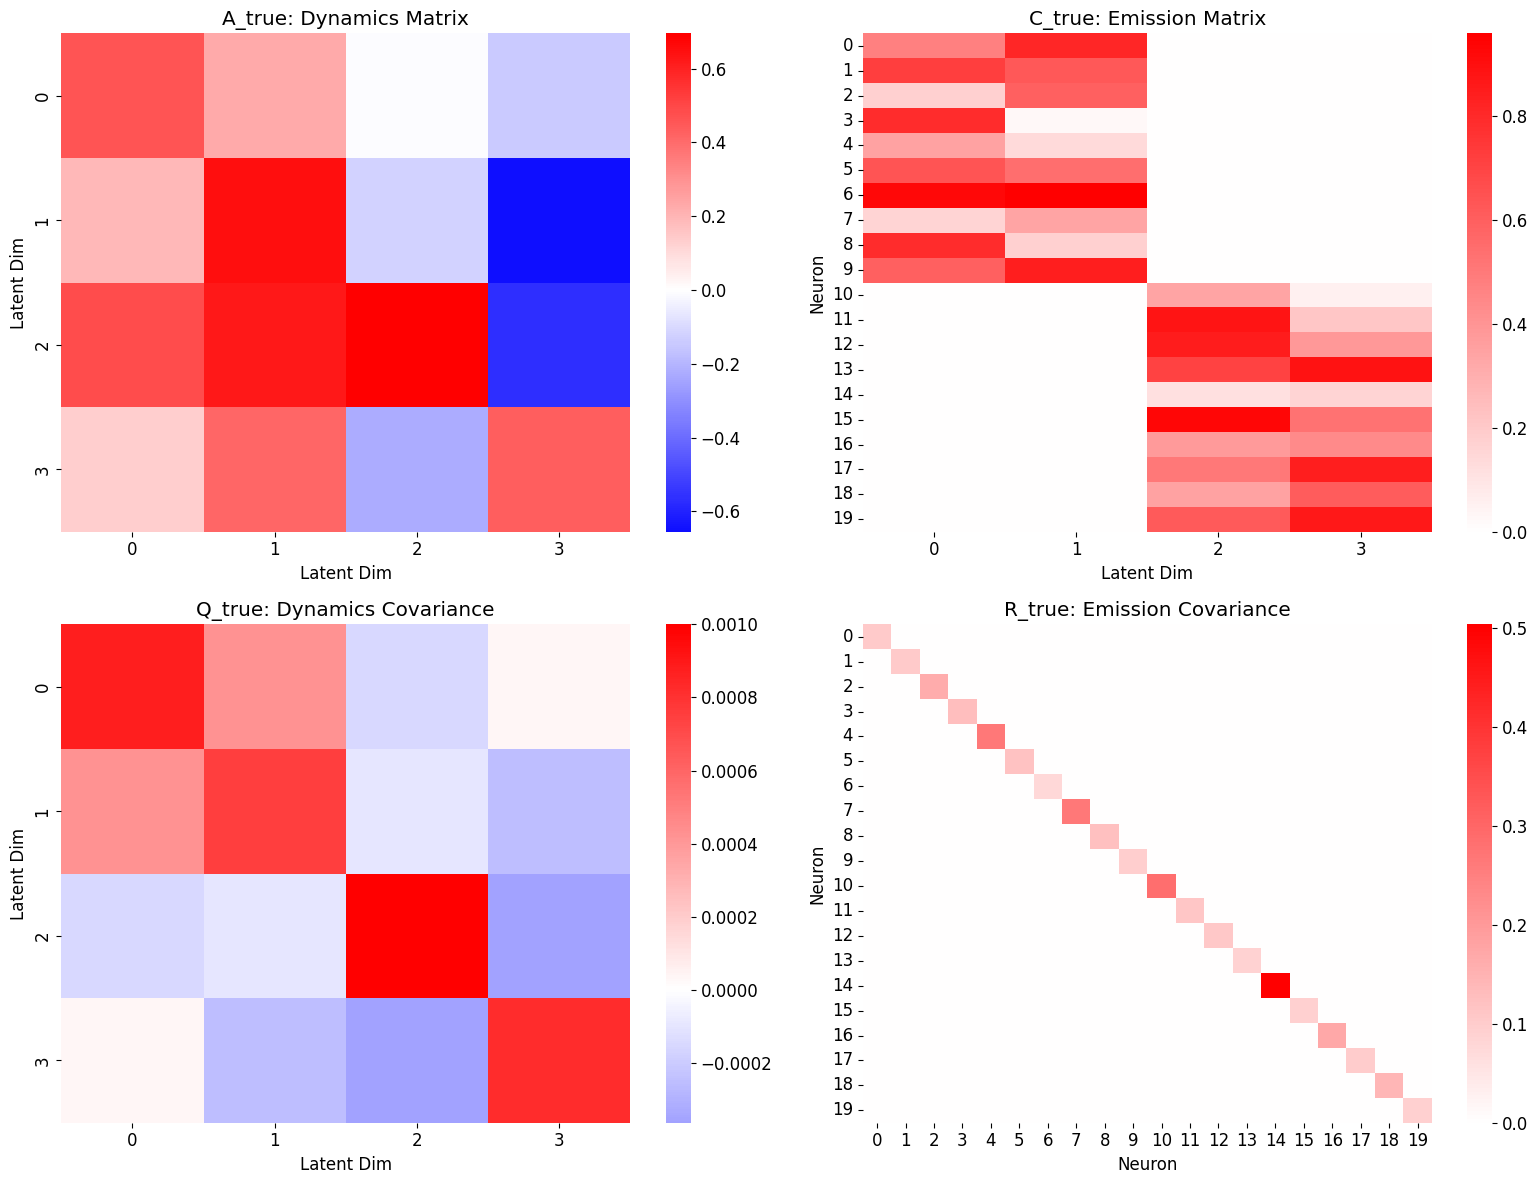

In [2]:
# Define dimensions and structure
D = 4  # Total state dimension
N = 20  # Number of observed neurons
T = 200  # Number of time steps
K = 2  # Number of cell types
key = jr.PRNGKey(0)  # Random key for reproducibility
# Step 1: Generate Synthetic Data for Demonstration
print(" STEP 1: GENERATING SYNTHETIC NEURAL DATA")
print("=" * 60)
states, observations, ctds, ctds_params = generate_synthetic_data(
    num_samples=1,
    num_timesteps=T,
    state_dim=D,
    emission_dim=N,
    cell_types=K
)
#Defining True Params
A_true = ctds_params.dynamics.weights
C_true = ctds_params.emissions.weights
Q_true = ctds_params.dynamics.cov
R_true = ctds_params.emissions.cov


#checking condition numbers
print(f"Condition number of A_true: {jnp.linalg.cond(A_true)}")
print(f"Condition number of C_true: {jnp.linalg.cond(C_true)}")
print(f"Condition number of Q_true: {jnp.linalg.cond(Q_true)}")
print(f"Condition number of R_true: {jnp.linalg.cond(R_true)}")
print(f"Condition number of observations: {jnp.linalg.cond(observations)}")

print(f"Model structure:")
print(f"  State dimension (D): {D}")
print(f"  Observation dimension (N): {N}")
print(f"  Time steps (T): {T}")
print(f"  Cell types: {len(ctds.constraints.cell_types)}")
print(f"  Cell type mask: {ctds.constraints.cell_type_mask}")
print(f"  Cell type dimensions: {ctds.constraints.cell_type_dimensions}")
print(f"  Dynamics mask: {ctds_params.dynamics.dynamics_mask}")
print(f"\n📊 Dataset Generated:")
print(f"  • A true shape: {A_true.shape}")
print(f"  • C true shape: {C_true.shape}")
print(f"  • Q true shape: {Q_true.shape}")
print(f"  • R true shape: {R_true.shape}")
#print(f"  • A true: {A_true.__array__()}")
#print(f"  • C true: {C_true.__array__()}")
#print(f"  • Q true: {Q_true.__array__()}")
#print(f"  • R true: {R_true.__array__()}")

# Step 2: Visualize the Synthetic Data
%matplotlib inline

# Visualize observations (neurons x time)
"""
plt.figure(figsize=(12, 4))
sns.heatmap(np.array(observations), cmap='bwr', cbar=True)
plt.title('Synthetic Observations (Neurons x Time)')
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.show()
"""
# Visualize all parameter matrices in subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Visualize A_true (dynamics weights)
sns.heatmap(np.array(A_true), cmap='bwr', center=0, cbar=True, ax=axes[0, 0])
axes[0, 0].set_title('A_true: Dynamics Matrix')
axes[0, 0].set_xlabel('Latent Dim')
axes[0, 0].set_ylabel('Latent Dim')

# Visualize C_true (emission weights)
sns.heatmap(np.array(C_true), cmap='bwr', center=0, cbar=True, ax=axes[0, 1])
axes[0, 1].set_title('C_true: Emission Matrix')
axes[0, 1].set_xlabel('Latent Dim')
axes[0, 1].set_ylabel('Neuron')

# Visualize Q_true (dynamics covariance)
sns.heatmap(np.array(Q_true), cmap='bwr', center=0, cbar=True, ax=axes[1, 0])
axes[1, 0].set_title('Q_true: Dynamics Covariance')
axes[1, 0].set_xlabel('Latent Dim')
axes[1, 0].set_ylabel('Latent Dim')

# Visualize R_true (emission covariance)
sns.heatmap(np.array(R_true), cmap='bwr', center=0, cbar=True, ax=axes[1, 1])
axes[1, 1].set_title('R_true: Emission Covariance')
axes[1, 1].set_xlabel('Neuron')
axes[1, 1].set_ylabel('Neuron')

plt.tight_layout()
plt.show()

 STEP 1b: GENERATING DATASETS FROM CTDS MODEL


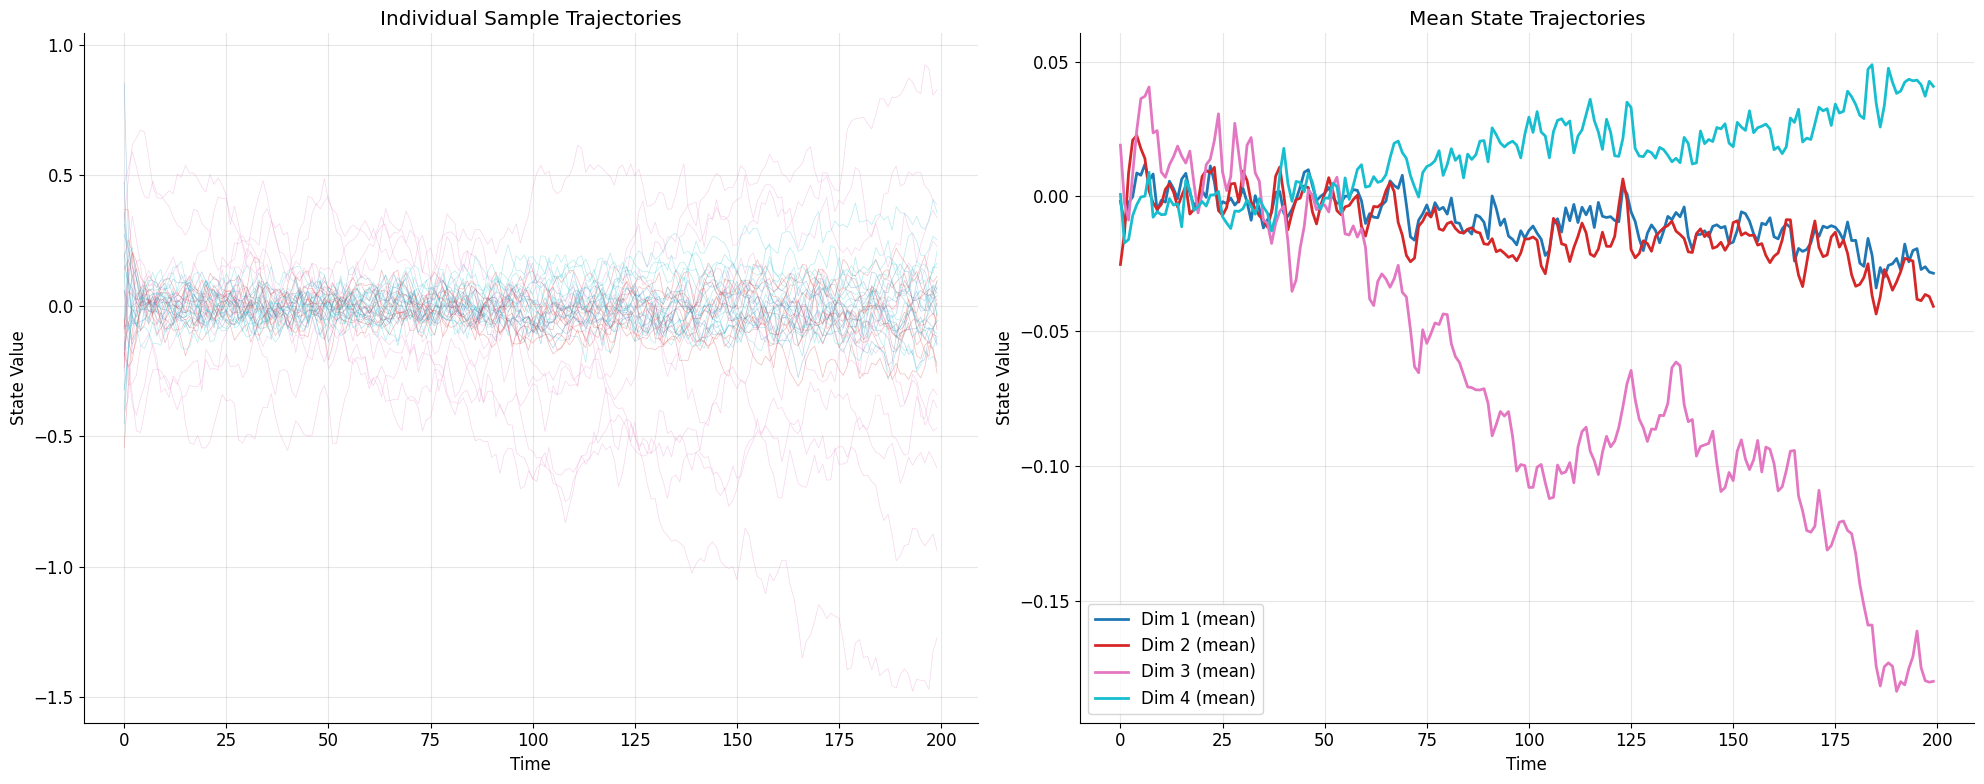

In [3]:
# Generate datasets from CTDS model using ground truth parameters
print(" STEP 1b: GENERATING DATASETS FROM CTDS MODEL")
print("=" * 60)
samples=50

datas=[]
states_list = []
keys= jr.split(key, samples)
for i in range(samples): 
    sampled_states, sampled_observations = ctds.sample(ctds_params, key=keys[i], num_timesteps=T)
    states_list.append(sampled_states)
    datas.append(sampled_observations)
#covert to jax array with shape (samples, T, N)
batched_states = jnp.array(states_list)
batched_observations = jnp.array(datas)

# Plot all true states in two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

colors = plt.cm.tab10(np.linspace(0, 1, D))

# Left subplot: Individual samples
for dim in range(D):
    for sample in range(min(10, batched_states.shape[0])):
        axes[0].plot(batched_states[sample, :, dim], 
                    color=colors[dim], alpha=0.3, linewidth=0.5)

axes[0].set_title('Individual Sample Trajectories')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('State Value')
axes[0].grid(True, alpha=0.3)
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

# Right subplot: Mean trajectories
for dim in range(D):
    mean_trajectory = jnp.mean(batched_states[:, :, dim], axis=0)
    axes[1].plot(mean_trajectory, color=colors[dim], linewidth=2, 
                label=f'Dim {dim+1} (mean)')

axes[1].set_title('Mean State Trajectories')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('State Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

## 3. Initialize and Fit CTDS Model

Initialize the model from observations and fit using EM algorithm.

In [4]:
# divide into train and test datasets
num_train_trials = int(0.8*sample)
train_datas = batched_observations[:num_train_trials]
test_datas = batched_observations[num_train_trials:]
train_obs=jnp.mean(train_datas, axis=0)
test_obs=jnp.mean(test_datas, axis=0)

# compute LLs for the test and train datasets
true_model_train_ll = ctds.log_prob(ctds_params,jnp.mean(batched_states[:num_train_trials], axis=0), train_obs)
true_model_test_ll = ctds.log_prob(ctds_params,jnp.mean(batched_states[num_train_trials:], axis=0), test_obs)
print("Train ll:", true_model_train_ll)
print("Test ll:",true_model_test_ll)


Train ll: 2109.8048070115683
Test ll: 2394.4054925762703


Fit CTDS with generated data


STEP 2: MODEL FITTING WITH EM ALGORITHM
 Initializing model parameters...
✅ Initialization completed in 9.52 seconds
 Running EM algorithm...


Iteration 1: log-likelihood = -48382.15387601523
Iteration 2: log-likelihood = -32481.22804024085
Iteration 3: log-likelihood = -24829.64387719541
Iteration 4: log-likelihood = -21045.65421820377
Iteration 5: log-likelihood = -19878.26897688544
Iteration 6: log-likelihood = -19906.776540149032
Iteration 7: log-likelihood = -19912.55091219045
Iteration 8: log-likelihood = -19941.842665131044
Iteration 9: log-likelihood = -19957.96784355319
Iteration 10: log-likelihood = -19969.70452897862
Iteration 11: log-likelihood = -19979.547623792663
Iteration 12: log-likelihood = -19986.08093597045
Iteration 13: log-likelihood = -19990.558812800686
Iteration 14: log-likelihood = -19995.58961297587
Iteration 15: log-likelihood = -20001.53597694125
Iteration 16: log-likelihood = -20007.729124596764
Iteration 17: log-likelihood = -20013.618370610595
Iteration 18: log-likelihood = -20018.91985131987
Iteration 19: log-likelihood = -20023.573634476284
Iteration 20: log-likelihood = -20027.645091228653
I

Text(0.5, 0, 'iteration')

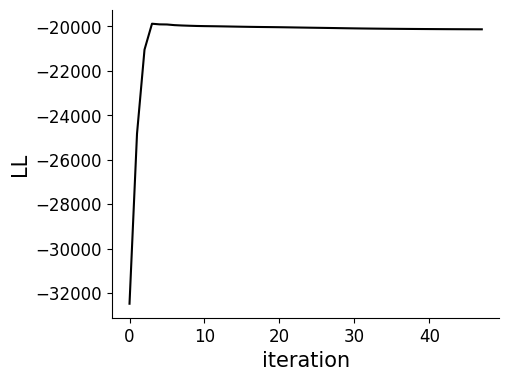

In [5]:
# Step 2: Model Fitting 
print("\nSTEP 2: MODEL FITTING WITH EM ALGORITHM")
print("=" * 60)


print(" Initializing model parameters...")
start_time = time.time()

# Initialize parameters from observations
demo_params_init = ctds.initialize(train_obs.T)
init_time = time.time() - start_time

print(f"✅ Initialization completed in {init_time:.2f} seconds")

# Fit model using EM algorithm
print(" Running EM algorithm...")
num_em_iters = 50


# Track timing
em_start_time = time.time()

# Run EM fitting with progress tracking 
# Refit on training data
params_fitted, test_lls = ctds.fit_em(
    demo_params_init, 
    train_datas, 
    num_iters=num_em_iters, 
    verbose=True
)

em_total_time = time.time() - em_start_time
em_per_iter_time = em_total_time / num_em_iters
from inference import DynamaxLGSSMBackend
print(f"\n✅ EM Algorithm Results:")
print(f"  • Total fitting time: {em_total_time:.2f} seconds")
print(f"  • Time per iteration: {em_per_iter_time:.3f} seconds")
print(f"  • Initial log-likelihood: {test_lls[0]:.2f}")
print(f"  • Final log-likelihood: {test_lls[-1]:.2f}")
print(f"  • Log-likelihood improvement: {test_lls[-1] - test_lls[1]:.2f}")


# Compute latent states using smoother
print("\n🔍 Computing fitted latent trajectories...")
smoothed_means, smoothed_covariances = DynamaxLGSSMBackend.smoother(params_fitted, observations)
states_fitted = smoothed_means #shape (T, D)

print(f"  • Fitted states shape: {states_fitted.shape}")
print(f"  • Smoothing completed successfully!")


#plot logs
plt.figure(figsize=(5, 4))
plt.plot(test_lls[1:], color = 'k')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('LL', fontsize=15)
plt.xlabel('iteration', fontsize=15)

## 4. Compute Accuracy Metrics

Calculate various error metrics to assess model performance.

In [6]:
#First recover true parameters from fitted model
A_rec, C_rec, Q_rec, info = align_single_region_ctds(
    C_true, params_fitted.emissions.weights, params_fitted.dynamics.weights, params_fitted.dynamics.cov, block_sizes=ctds.constraints.cell_type_dimensions, ridge=1e-6
)
print("mean |matched corr|:", info["mean_abs_matched_corr"])

mean |matched corr|: 0.5635193056958845


Computing accuracy metrics...
✅ Accuracy Metrics:

Absolute Frobenius Errors:
  Dynamics (A):     1.4378
  Emissions (C):    2.6304
  Process noise (Q): 0.5692
  Obs noise (R):    0.5305

Relative Errors (%):
  Dynamics (A):     82.35%
  Emissions (C):    69.11%
  Process noise (Q): 29062.11%
  Obs noise (R):    63.59%


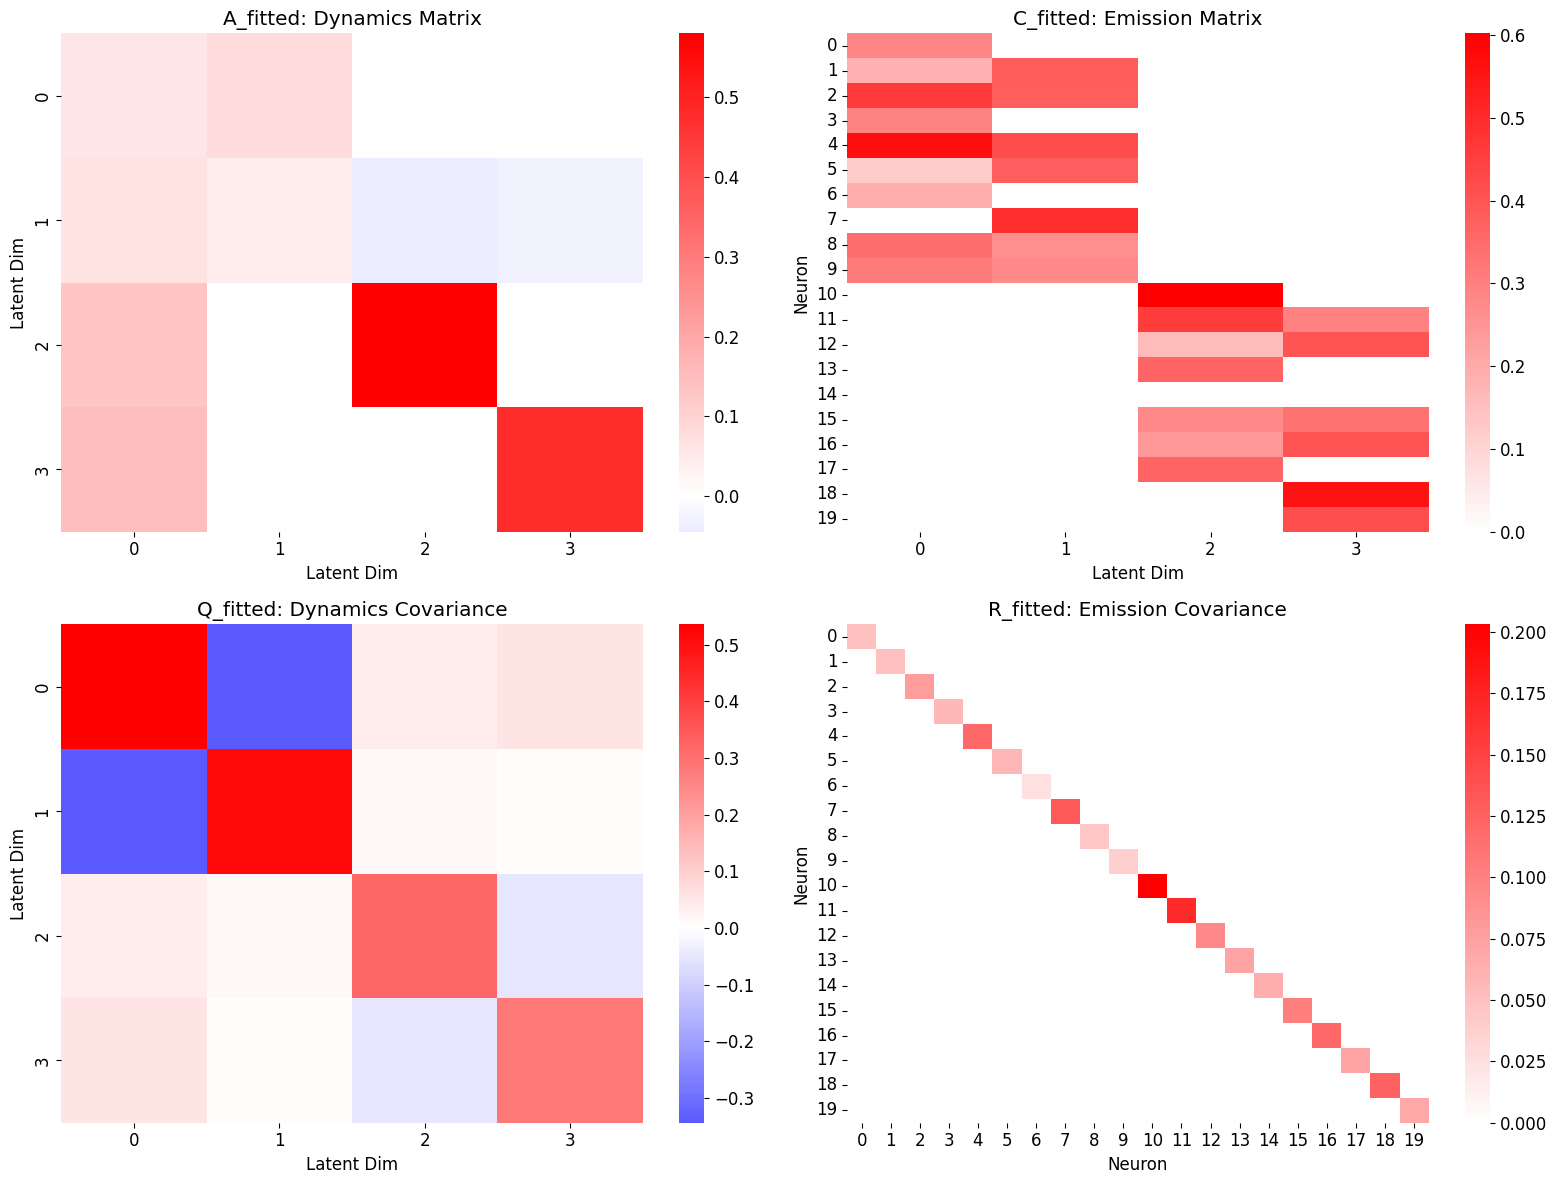

dynamics [[ 5.69595512e-02  7.82336036e-02  8.15242639e-12  2.14778170e-11]
 [ 6.62385366e-02  4.15127607e-02 -4.44440748e-02 -2.83561434e-02]
 [ 1.35372009e-01  7.25373497e-04  5.80183869e-01 -6.71811031e-12]
 [ 1.47885622e-01 -5.36144672e-11 -1.66531858e-12  4.80092414e-01]]
emissions [[0.28445844 0.         0.         0.        ]
 [0.18580272 0.38108364 0.         0.        ]
 [0.46227644 0.38004201 0.         0.        ]
 [0.29253019 0.         0.         0.        ]
 [0.56806555 0.42156836 0.         0.        ]
 [0.11896837 0.37752304 0.         0.        ]
 [0.18819704 0.         0.         0.        ]
 [0.         0.49061619 0.         0.        ]
 [0.33974652 0.26694849 0.         0.        ]
 [0.31239329 0.2795247  0.         0.        ]
 [0.         0.         0.6021017  0.        ]
 [0.         0.         0.45829222 0.29391263]
 [0.         0.         0.16253516 0.40283731]
 [0.         0.         0.36290853 0.        ]
 [0.         0.         0.         0.        ]
 [0.   

In [ ]:
# Compute accuracy metrics
print("Computing accuracy metrics...")


A_error = jnp.linalg.norm(A_rec - A_true, 'fro')
C_error = jnp.linalg.norm(C_rec - C_true, 'fro')
Q_error = jnp.linalg.norm(Q_rec - Q_true, 'fro')
R_error = jnp.linalg.norm(params_fitted.emissions.cov - R_true, 'fro')
"""
A_error = jnp.linalg.norm(params_fitted.dynamics.weights - A_true, 'fro')
C_error = jnp.linalg.norm(params_fitted.emissions.weights - C_true, 'fro')
Q_error = jnp.linalg.norm(params_fitted.dynamics.cov - Q_true, 'fro')
R_error = jnp.linalg.norm(params_fitted.emissions.cov - R_true, 'fro')
"""
# Relative errors (normalized by true parameter magnitude)
A_rel_error = A_error / jnp.linalg.norm(A_true, 'fro')
C_rel_error = C_error / jnp.linalg.norm(C_true, 'fro')
Q_rel_error = Q_error / jnp.linalg.norm(Q_true, 'fro')
R_rel_error = R_error / jnp.linalg.norm(R_true, 'fro')

print("✅ Accuracy Metrics:")
print(f"\nAbsolute Frobenius Errors:")
print(f"  Dynamics (A):     {A_error:.4f}")
print(f"  Emissions (C):    {C_error:.4f}")
print(f"  Process noise (Q): {Q_error:.4f}")
print(f"  Obs noise (R):    {R_error:.4f}")

print(f"\nRelative Errors (%):")
print(f"  Dynamics (A):     {A_rel_error*100:.2f}%")
print(f"  Emissions (C):    {C_rel_error*100:.2f}%")
print(f"  Process noise (Q): {Q_rel_error*100:.2f}%")
print(f"  Obs noise (R):    {R_rel_error*100:.2f}%")

"""

# Visualize all parameter matrices in subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Visualize A_true (dynamics weights)
sns.heatmap(np.array(params_fitted.dynamics.weights), cmap='bwr', center=0, cbar=True, ax=axes[0, 0])
axes[0, 0].set_title('A_true: Dynamics Matrix')
axes[0, 0].set_xlabel('Latent Dim')
axes[0, 0].set_ylabel('Latent Dim')

# Visualize C_true (emission weights)
sns.heatmap(np.array(params_fitted.emissions.weights), cmap='bwr', center=0, cbar=True, ax=axes[0, 1])
axes[0, 1].set_title('C_true: Emission Matrix')
axes[0, 1].set_xlabel('Latent Dim')
axes[0, 1].set_ylabel('Neuron')

# Visualize Q_true (dynamics covariance)
sns.heatmap(np.array(params_fitted.dynamics.cov), cmap='bwr', center=0, cbar=True, ax=axes[1, 0])
axes[1, 0].set_title('Q_true: Dynamics Covariance')
axes[1, 0].set_xlabel('Latent Dim')
axes[1, 0].set_ylabel('Latent Dim')

# Visualize R_true (emission covariance)
sns.heatmap(np.array(params_fitted.emissions.cov), cmap='bwr', center=0, cbar=True, ax=axes[1, 1])
axes[1, 1].set_title('R_true: Emission Covariance')
axes[1, 1].set_xlabel('Neuron')
axes[1, 1].set_ylabel('Neuron')

plt.tight_layout()
plt.show()
"""
# Visualize all parameter matrices in subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Visualize A_true (dynamics weights)
sns.heatmap(np.array(A_rec), cmap='bwr', center=0, cbar=True, ax=axes[0, 0])
axes[0, 0].set_title('A_fitted: Dynamics Matrix')
axes[0, 0].set_xlabel('Latent Dim')
axes[0, 0].set_ylabel('Latent Dim')

# Visualize C_true (emission weights)
sns.heatmap(np.array(params_fitted.emissions.weights), cmap='bwr', center=0, cbar=True, ax=axes[0, 1])
axes[0, 1].set_title('C_fitted: Emission Matrix')
axes[0, 1].set_xlabel('Latent Dim')
axes[0, 1].set_ylabel('Neuron')

# Visualize Q_true (dynamics covariance)
sns.heatmap(np.array(params_fitted.dynamics.cov), cmap='bwr', center=0, cbar=True, ax=axes[1, 0])
axes[1, 0].set_title('Q_fitted: Dynamics Covariance')
axes[1, 0].set_xlabel('Latent Dim')
axes[1, 0].set_ylabel('Latent Dim')

# Visualize R_true (emission covariance)
sns.heatmap(np.array(params_fitted.emissions.cov), cmap='bwr', center=0, cbar=True, ax=axes[1, 1])
axes[1, 1].set_title('R_fitted: Emission Covariance')
axes[1, 1].set_xlabel('Neuron')
axes[1, 1].set_ylabel('Neuron')

plt.tight_layout()
plt.show()

print("dynamics",params_fitted.dynamics.weights)
print("emissions",params_fitted.emissions.weights)
print("dynamics_cov",params_fitted.dynamics.cov)
print("emissions_cov",params_fitted.emissions.cov)

In [8]:
# Compute latent trajectory recovery
print("Computing latent trajectory metrics...")
states_true=jnp.mean(batched_states[:num_train_trials], axis=0)
# Run smoother to get fitted latent states
posterior = ctds.smoother(params_fitted, train_obs)
states_fitted = posterior[0]  

# Latent trajectory MSE
latent_mse = jnp.mean((states_fitted - states_true)**2)

# R² for latent trajectories (per dimension)
def compute_r_squared(y_true, y_pred):
    ss_res = jnp.sum((y_true - y_pred)**2)
    ss_tot = jnp.sum((y_true - jnp.mean(y_true))**2)
    return 1 - (ss_res / ss_tot)

latent_r2_per_dim = jnp.array([
    compute_r_squared(states_true[:, i], states_fitted[:, i]) 
    for i in range(D)
])
latent_r2_avg = jnp.mean(latent_r2_per_dim)

# Prediction R² for observations
observations_pred = states_fitted @ params_fitted.emissions.weights.T
obs_r2_per_neuron = jnp.array([
    compute_r_squared(observations[:, i], observations_pred[:, i])
    for i in range(N)
])
obs_r2_avg = jnp.mean(obs_r2_per_neuron)

print("✅ Trajectory Recovery Metrics:")
print(f"  Latent MSE:           {latent_mse:.6f}")
print(f"  Latent R² (avg):      {latent_r2_avg:.4f}")
print(f"  Latent R² (per dim):  {latent_r2_per_dim}")
print(f"  Observation R² (avg): {obs_r2_avg:.4f}")
print(f"  Obs R² range:         [{jnp.min(obs_r2_per_neuron):.3f}, {jnp.max(obs_r2_per_neuron):.3f}]")

Computing latent trajectory metrics...
✅ Trajectory Recovery Metrics:
  Latent MSE:           0.025722
  Latent R² (avg):      -60.3896
  Latent R² (per dim):  [-80.47080925 -99.986896    -2.4445005  -58.6563408 ]
  Observation R² (avg): -0.3128
  Obs R² range:         [-1.420, 0.004]



🔍 OBSERVATION PREDICTIONS FROM RECOVERED PARAMETERS
Generating predictions from recovered parameters...
✅ Prediction Results:
  Recovered params - Mean correlation: 0.5070
  Recovered params - Correlation range: [0.4203, 0.6130]
  Fitted params - Mean correlation: 0.5112
  Fitted params - Correlation range: [0.4338, 0.6130]
  True params - Mean correlation: 0.0082
  True params - Correlation range: [-0.1064, 0.1562]


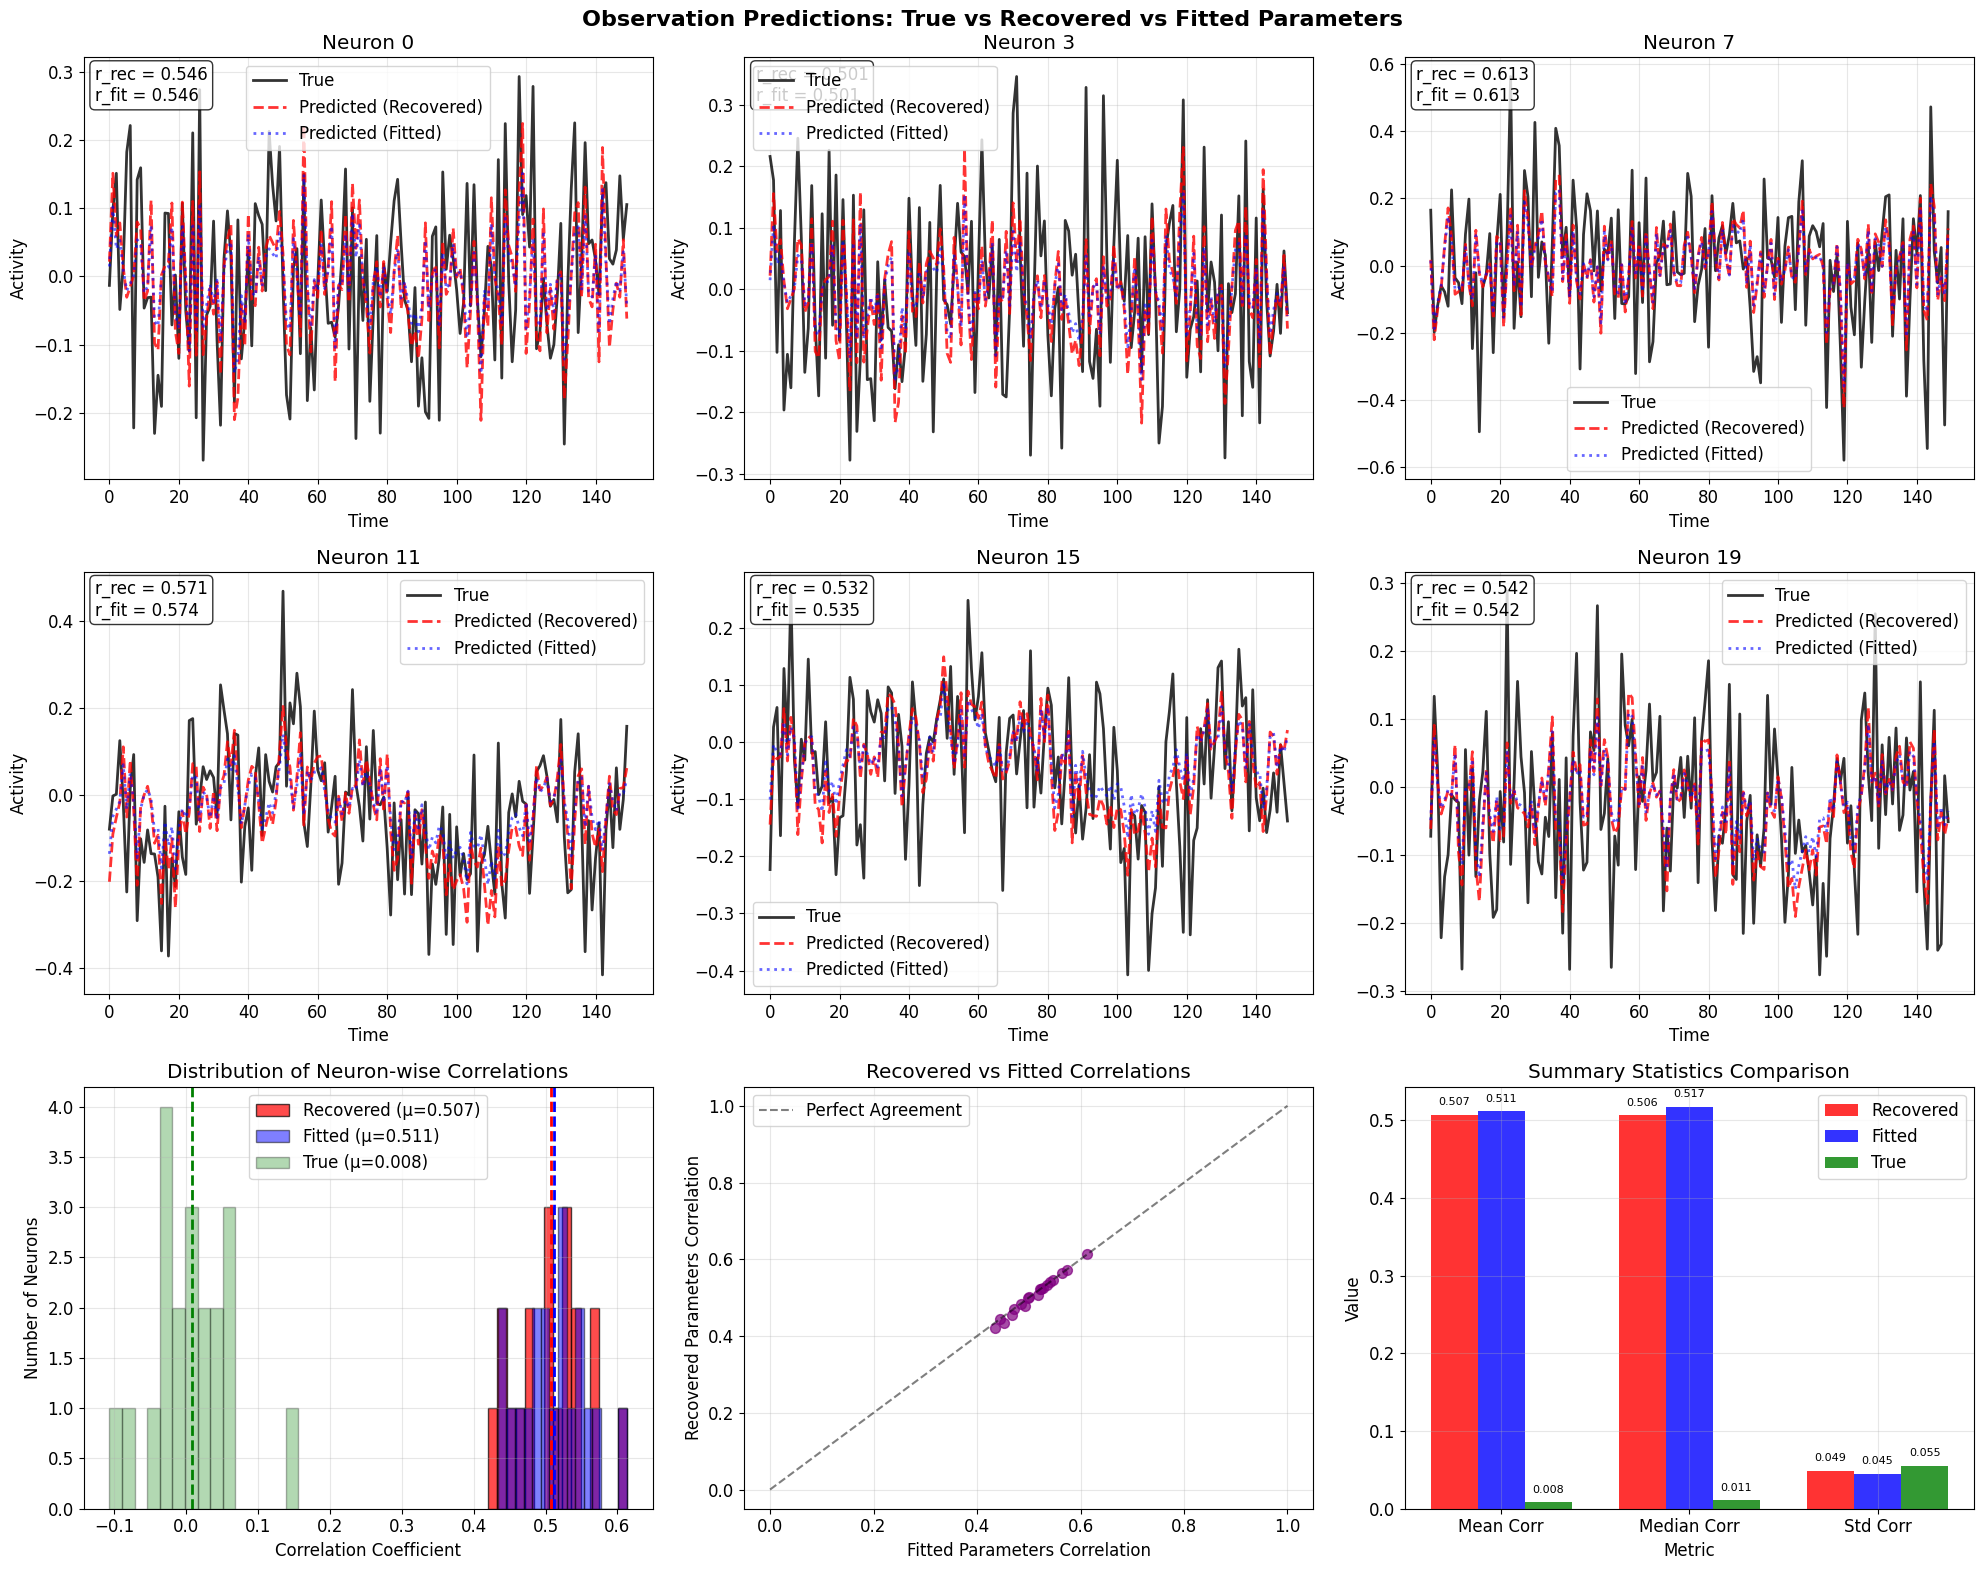


📊 Detailed Analysis:
  Neurons with correlation > 0.8:
    Recovered: 0/20 (0.0%)
    Fitted:    0/20 (0.0%)
    True:      0/20 (0.0%)
  Neurons with correlation > 0.5:
    Recovered: 11/20 (55.0%)
    Fitted:    11/20 (55.0%)
    True:      0/20 (0.0%)

📈 Prediction Quality Metrics:
  RMSE:
    Recovered: 0.1319
    Fitted:    0.1319
    True:      0.4664
  R²:
    Recovered: 0.2245
    Fitted:    0.2251
    True:      -8.6921
✅ Observation prediction analysis completed!


In [9]:
# Generate observation predictions from recovered parameters and compare to true observations
print("\n🔍 OBSERVATION PREDICTIONS FROM RECOVERED PARAMETERS")
print("=" * 60)

# Generate predictions using recovered parameters on training data
print("Generating predictions from recovered parameters...")

# Use the fitted latent states but with recovered emission matrix
obs_pred_recovered = states_fitted @ C_rec.T  # Predict using recovered C
obs_pred_fitted = states_fitted @ params_fitted.emissions.weights.T  # Predict using fitted C
#obs_pred_true = states_true @ C_true.T  # Predict using true C and true states
obs_pred_true =observations
# Compute correlation coefficients between true and predicted observations
def compute_correlations(y_true, y_pred):
    """Compute correlation coefficient for each neuron"""
    correlations = []
    for neuron in range(y_true.shape[1]):
        corr = jnp.corrcoef(y_true[:, neuron], y_pred[:, neuron])[0, 1]
        correlations.append(corr)
    return jnp.array(correlations)

# Compute correlations for both recovered and fitted parameters
corr_recovered = compute_correlations(train_obs, obs_pred_recovered)
corr_fitted = compute_correlations(train_obs, obs_pred_fitted)
corr_true = compute_correlations(train_obs, obs_pred_true)

print(f"✅ Prediction Results:")
print(f"  Recovered params - Mean correlation: {jnp.nanmean(corr_recovered):.4f}")
print(f"  Recovered params - Correlation range: [{jnp.nanmin(corr_recovered):.4f}, {jnp.nanmax(corr_recovered):.4f}]")
print(f"  Fitted params - Mean correlation: {jnp.nanmean(corr_fitted):.4f}")
print(f"  Fitted params - Correlation range: [{jnp.nanmin(corr_fitted):.4f}, {jnp.nanmax(corr_fitted):.4f}]")
print(f"  True params - Mean correlation: {jnp.nanmean(corr_true):.4f}")
print(f"  True params - Correlation range: [{jnp.nanmin(corr_true):.4f}, {jnp.nanmax(corr_true):.4f}]")

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 16))

# Select neurons to plot (evenly spaced across all neurons)
n_neurons_to_plot = 6
neuron_indices = jnp.linspace(0, N-1, n_neurons_to_plot).astype(int)
time_window = slice(0, min(150, T))  # Show first 150 time points
t_range = jnp.arange(time_window.start, time_window.start + len(train_obs[time_window, 0]))

# Plot 1: Individual neuron traces (recovered parameters)
for i, neuron_idx in enumerate(neuron_indices):
    ax = plt.subplot(3, 3, i+1)
    
    # True vs predicted for this neuron
    true_trace = train_obs[time_window, neuron_idx]
    pred_trace_recovered = obs_pred_recovered[time_window, neuron_idx]
    pred_trace_fitted = obs_pred_fitted[time_window, neuron_idx]
    
    ax.plot(t_range, true_trace, 'k-', linewidth=2, alpha=0.8, label='True')
    ax.plot(t_range, pred_trace_recovered, 'r--', linewidth=2, alpha=0.8, label='Predicted (Recovered)')
    ax.plot(t_range, pred_trace_fitted, 'b:', linewidth=2, alpha=0.6, label='Predicted (Fitted)')
    
    # Add correlation coefficients
    corr_rec = corr_recovered[neuron_idx]
    corr_fit = corr_fitted[neuron_idx]
    ax.text(0.02, 0.98, f'r_rec = {corr_rec:.3f}\nr_fit = {corr_fit:.3f}', 
           transform=ax.transAxes, verticalalignment='top', 
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Activity')
    ax.set_title(f'Neuron {neuron_idx}')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Plot 2: Histogram of correlation coefficients
ax_hist = plt.subplot(3, 3, 7)
ax_hist.hist(corr_recovered, bins=15, alpha=0.7, color='red', edgecolor='black', 
             label=f'Recovered (μ={jnp.nanmean(corr_recovered):.3f})')
ax_hist.hist(corr_fitted, bins=15, alpha=0.5, color='blue', edgecolor='black',
             label=f'Fitted (μ={jnp.nanmean(corr_fitted):.3f})')
ax_hist.hist(corr_true, bins=15, alpha=0.3, color='green', edgecolor='black',
             label=f'True (μ={jnp.nanmean(corr_true):.3f})')
ax_hist.axvline(jnp.nanmean(corr_recovered), color='red', linestyle='--', linewidth=2)
ax_hist.axvline(jnp.nanmean(corr_fitted), color='blue', linestyle='--', linewidth=2)
ax_hist.axvline(jnp.nanmean(corr_true), color='green', linestyle='--', linewidth=2)
ax_hist.set_xlabel('Correlation Coefficient')
ax_hist.set_ylabel('Number of Neurons')
ax_hist.set_title('Distribution of Neuron-wise Correlations')
ax_hist.legend()
ax_hist.grid(True, alpha=0.3)

# Plot 3: Scatter plot of correlations (recovered vs fitted)
ax_scatter = plt.subplot(3, 3, 8)
ax_scatter.scatter(corr_fitted, corr_recovered, alpha=0.7, s=50, c='purple')
ax_scatter.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Agreement')
ax_scatter.set_xlabel('Fitted Parameters Correlation')
ax_scatter.set_ylabel('Recovered Parameters Correlation')
ax_scatter.set_title('Recovered vs Fitted Correlations')
ax_scatter.legend()
ax_scatter.grid(True, alpha=0.3)

# Plot 4: Summary statistics comparison
ax_summary = plt.subplot(3, 3, 9)
metrics = ['Mean Corr', 'Median Corr', 'Std Corr']
recovered_metrics = [jnp.nanmean(corr_recovered), jnp.nanmedian(corr_recovered), jnp.nanstd(corr_recovered)]
fitted_metrics = [jnp.nanmean(corr_fitted), jnp.nanmedian(corr_fitted), jnp.nanstd(corr_fitted)]
true_metrics = [jnp.nanmean(corr_true), jnp.nanmedian(corr_true), jnp.nanstd(corr_true)]

x_pos = jnp.arange(len(metrics))
width = 0.25

bars1 = ax_summary.bar(x_pos - width, recovered_metrics, width, label='Recovered', alpha=0.8, color='red')
bars2 = ax_summary.bar(x_pos, fitted_metrics, width, label='Fitted', alpha=0.8, color='blue')
bars3 = ax_summary.bar(x_pos + width, true_metrics, width, label='True', alpha=0.8, color='green')

ax_summary.set_xlabel('Metric')
ax_summary.set_ylabel('Value')
ax_summary.set_title('Summary Statistics Comparison')
ax_summary.set_xticks(x_pos)
ax_summary.set_xticklabels(metrics)
ax_summary.legend()
ax_summary.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax_summary.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.suptitle('Observation Predictions: True vs Recovered vs Fitted Parameters', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Additional detailed analysis
print(f"\n📊 Detailed Analysis:")
print(f"  Neurons with correlation > 0.8:")
print(f"    Recovered: {jnp.sum(corr_recovered > 0.8)}/{N} ({100*jnp.mean(corr_recovered > 0.8):.1f}%)")
print(f"    Fitted:    {jnp.sum(corr_fitted > 0.8)}/{N} ({100*jnp.mean(corr_fitted > 0.8):.1f}%)")
print(f"    True:      {jnp.sum(corr_true > 0.8)}/{N} ({100*jnp.mean(corr_true > 0.8):.1f}%)")

print(f"  Neurons with correlation > 0.5:")
print(f"    Recovered: {jnp.sum(corr_recovered > 0.5)}/{N} ({100*jnp.mean(corr_recovered > 0.5):.1f}%)")
print(f"    Fitted:    {jnp.sum(corr_fitted > 0.5)}/{N} ({100*jnp.mean(corr_fitted > 0.5):.1f}%)")
print(f"    True:      {jnp.sum(corr_true > 0.5)}/{N} ({100*jnp.mean(corr_true > 0.5):.1f}%)")

# Compute RMSE and R² for all parameter sets
rmse_recovered = jnp.sqrt(jnp.mean((obs_pred_recovered - train_obs)**2))
rmse_fitted = jnp.sqrt(jnp.mean((obs_pred_fitted - train_obs)**2))
rmse_true = jnp.sqrt(jnp.mean((obs_pred_true - train_obs)**2))

r2_recovered = compute_r_squared(train_obs.flatten(), obs_pred_recovered.flatten())
r2_fitted = compute_r_squared(train_obs.flatten(), obs_pred_fitted.flatten())
r2_true = compute_r_squared(train_obs.flatten(), obs_pred_true.flatten())

print(f"\n📈 Prediction Quality Metrics:")
print(f"  RMSE:")
print(f"    Recovered: {rmse_recovered:.4f}")
print(f"    Fitted:    {rmse_fitted:.4f}")
print(f"    True:      {rmse_true:.4f}")
print(f"  R²:")
print(f"    Recovered: {r2_recovered:.4f}")
print(f"    Fitted:    {r2_fitted:.4f}")
print(f"    True:      {r2_true:.4f}")

print("✅ Observation prediction analysis completed!")

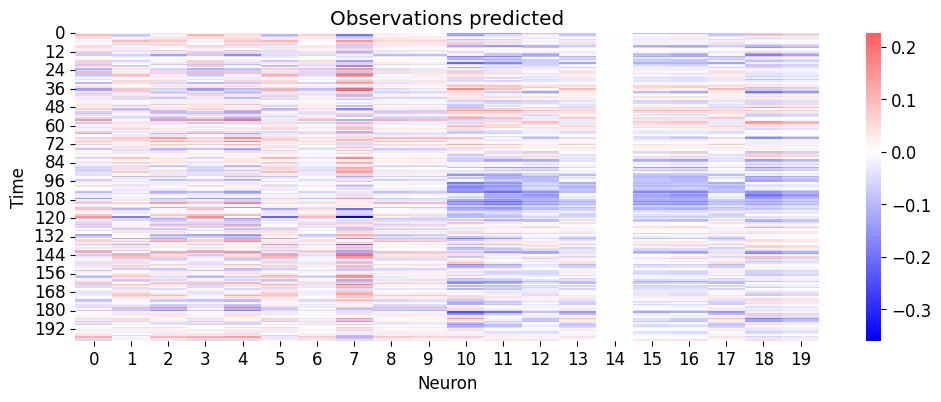

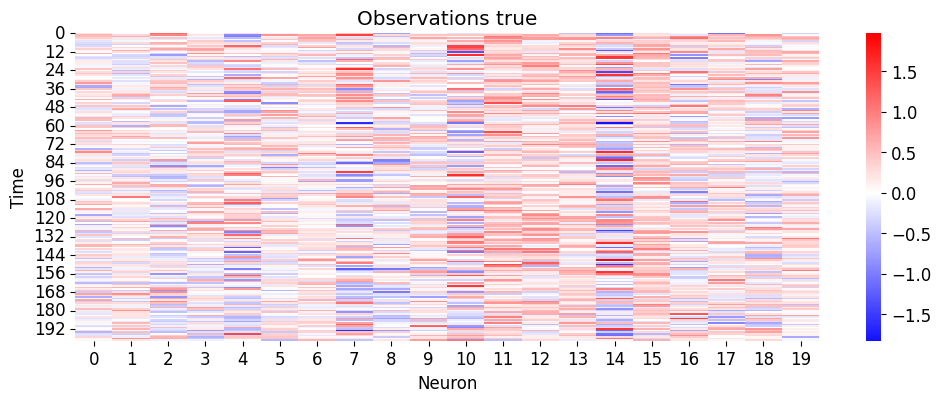

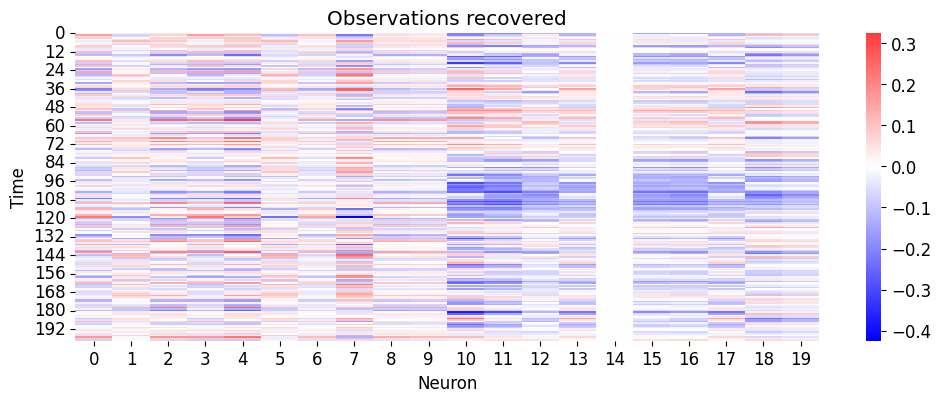

In [10]:
plt.figure(figsize=(12, 4))
sns.heatmap(np.array(obs_pred_fitted),center=0, cmap='bwr', cbar=True)
plt.title('Observations predicted')
plt.ylabel('Time')
plt.xlabel('Neuron')
plt.show()


plt.figure(figsize=(12, 4))
sns.heatmap(np.array(obs_pred_true),center=0, cmap='bwr', cbar=True)
plt.title('Observations true')
plt.ylabel('Time')
plt.xlabel('Neuron')
plt.show()

plt.figure(figsize=(12, 4))
sns.heatmap(np.array(obs_pred_recovered),center=0, cmap='bwr', cbar=True)
plt.title('Observations recovered')
plt.ylabel('Time')
plt.xlabel('Neuron')
plt.show()

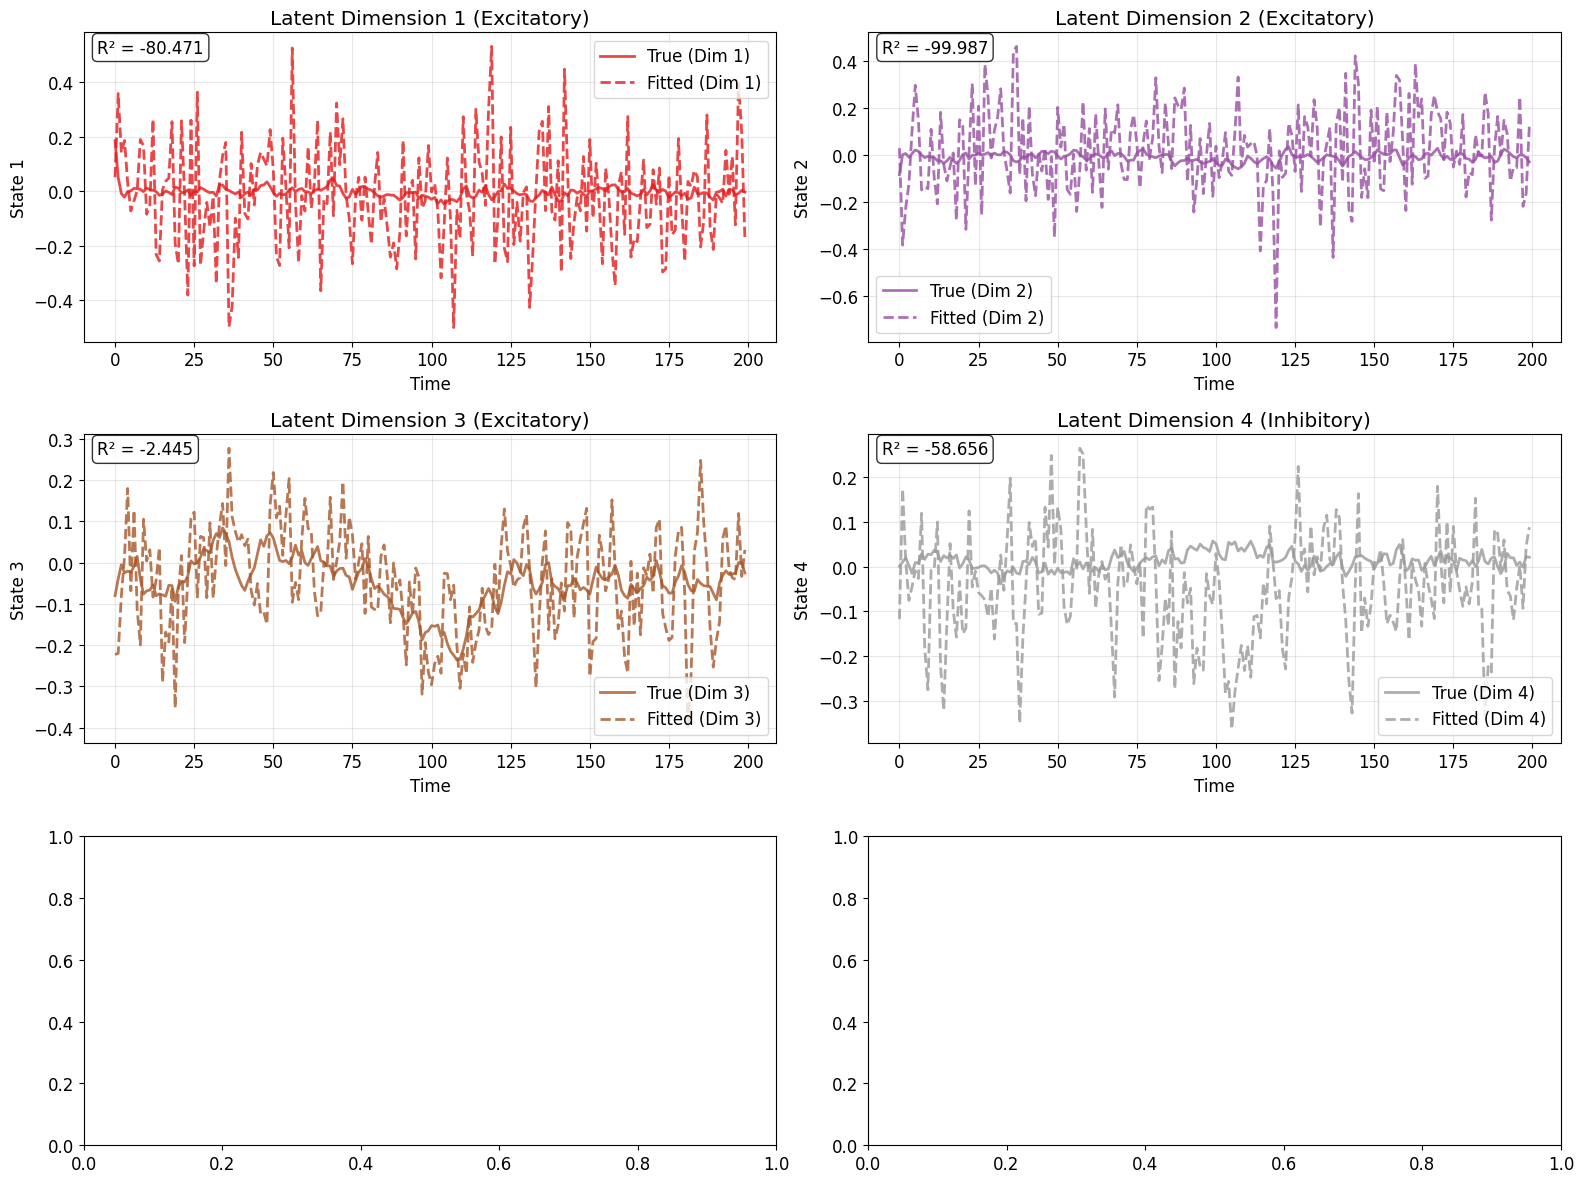

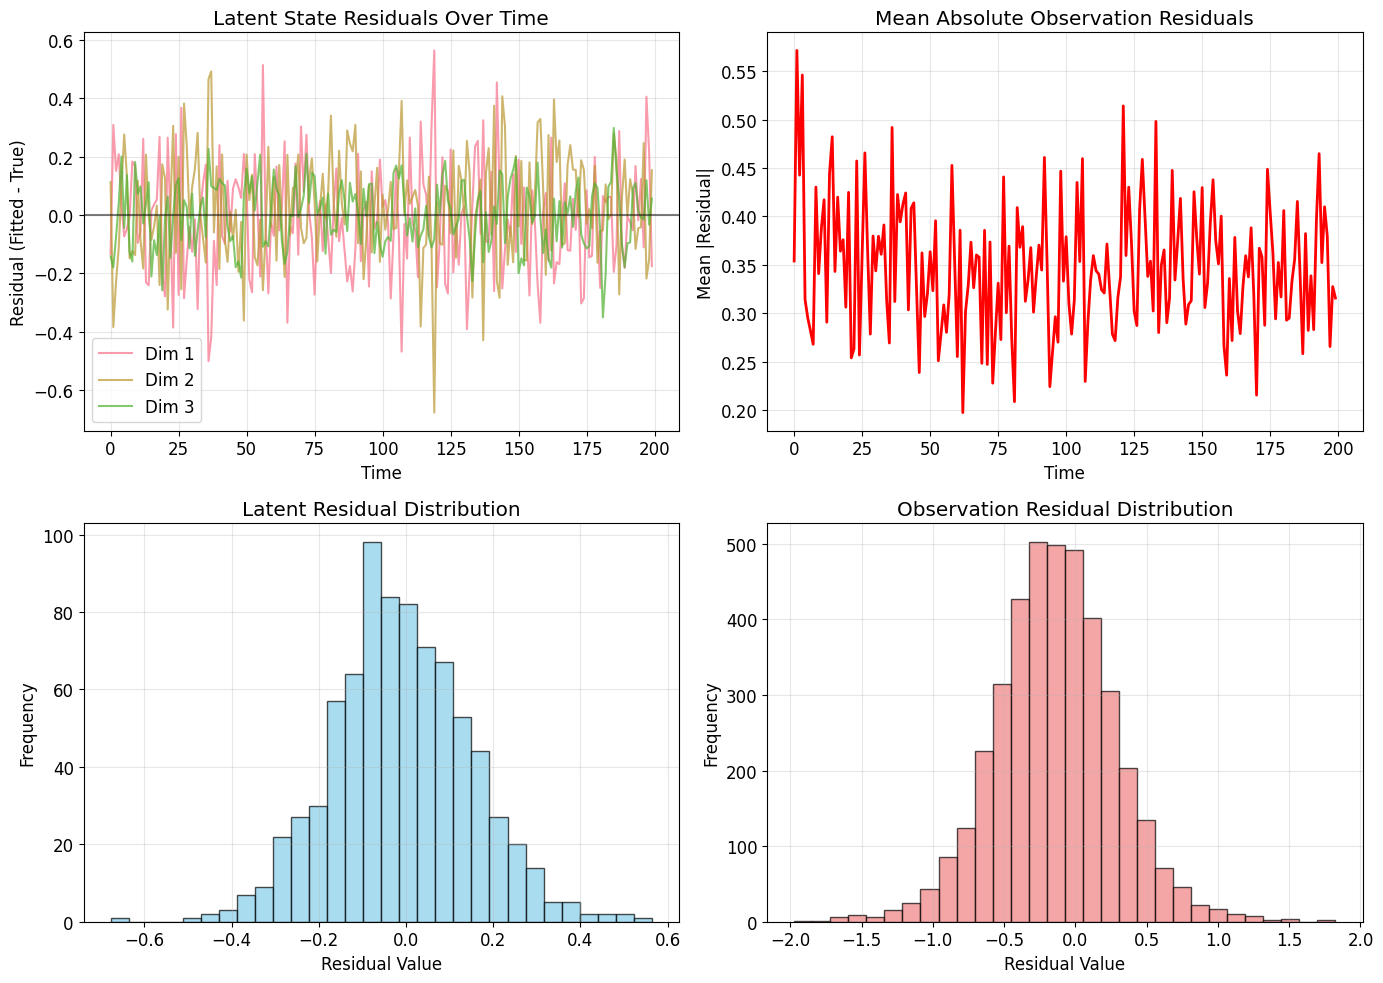

✅ Latent trajectory comparison plots created


In [11]:
# Latent trajectory comparison
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

# Plot first 6 dimensions (all dimensions in our case)
time_points = jnp.arange(T)
colors = plt.cm.Set1(np.linspace(0, 1, D))

for i in range(D):
    ax = axes[i]
    
    # Plot true and fitted trajectories
    ax.plot(time_points, states_true[:, i], color=colors[i], linewidth=2, 
           label=f'True (Dim {i+1})', alpha=0.8)
    ax.plot(time_points, states_fitted[:, i], color=colors[i], linewidth=2, 
           linestyle='--', label=f'Fitted (Dim {i+1})', alpha=0.8)
    
    # Add R² score
    r2_score = latent_r2_per_dim[i]
    ax.text(0.02, 0.98, f'R² = {r2_score:.3f}', transform=ax.transAxes, 
           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Time')
    ax.set_ylabel(f'State {i+1}')
    ax.set_title(f'Latent Dimension {i+1} {"(Excitatory)" if i < 3 else "(Inhibitory)"}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Residual analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Latent residuals over time
latent_residuals = states_fitted - states_true
for i in range(min(D-1, D)):
    axes[0, 0].plot(latent_residuals[:, i], label=f'Dim {i+1}', alpha=0.7)
axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[0, 0].set_title('Latent State Residuals Over Time')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residual (Fitted - True)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Observation residuals over time
obs_residuals = observations_pred - observations
axes[0, 1].plot(jnp.mean(jnp.abs(obs_residuals), axis=1), color='red', linewidth=2)
axes[0, 1].set_title('Mean Absolute Observation Residuals')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Mean |Residual|')
axes[0, 1].grid(True, alpha=0.3)

# Residual distributions
axes[1, 0].hist(latent_residuals.flatten(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Latent Residual Distribution')
axes[1, 0].set_xlabel('Residual Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(obs_residuals.flatten(), bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 1].set_title('Observation Residual Distribution')
axes[1, 1].set_xlabel('Residual Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("✅ Latent trajectory comparison plots created")

## 7. Numerical Stability Checks

Verify that the fitted model has good numerical properties.

In [12]:
# Numerical stability analysis
print("Performing numerical stability checks...")

# 1. Check eigenvalues of fitted dynamics matrix
A_fitted = params_fitted.dynamics.weights
eigenvals_fitted = jnp.linalg.eigvals(A_fitted)
max_eigenval = jnp.max(jnp.abs(eigenvals_fitted))
is_stable = max_eigenval < 1.0

print("✅ Dynamics Matrix Stability:")
print(f"  Eigenvalues: {eigenvals_fitted}")
print(f"  Max eigenvalue magnitude: {max_eigenval:.4f}")
print(f"  System is {'stable' if is_stable else 'UNSTABLE'}")
print(f"  Stability margin: {1.0 - max_eigenval:.4f}")

# 2. Check positive semi-definiteness of Q and R
Q_fitted = params_fitted.dynamics.cov
R_fitted = params_fitted.emissions.cov

# Check Q (process noise)
Q_eigenvals = jnp.linalg.eigvals(Q_fitted)
Q_is_psd = jnp.all(Q_eigenvals >= -1e-10)  # Allow small numerical errors
Q_condition_number = jnp.max(Q_eigenvals) / jnp.max(Q_eigenvals[Q_eigenvals > 1e-10])

print(f"\nProcess Noise Covariance (Q):")
print(f"  Eigenvalues: {Q_eigenvals}")
print(f"  Is positive semi-definite: {Q_is_psd}")
print(f"  Condition number: {Q_condition_number:.2e}")
print(f"  Determinant: {jnp.linalg.det(Q_fitted):.2e}")

# Check R (observation noise)
R_eigenvals = jnp.linalg.eigvals(R_fitted)
R_is_psd = jnp.all(R_eigenvals >= -1e-10)
R_condition_number = jnp.max(R_eigenvals) / jnp.max(R_eigenvals[R_eigenvals > 1e-10])

print(f"\nObservation Noise Covariance (R):")
print(f"  Eigenvalues range: [{jnp.min(R_eigenvals):.2e}, {jnp.max(R_eigenvals):.2e}]")
print(f"  Is positive semi-definite: {R_is_psd}")
print(f"  Condition number: {R_condition_number:.2e}")
print(f"  Determinant: {jnp.linalg.det(R_fitted):.2e}")

# 3. Check matrix norms and conditioning
A_condition = jnp.linalg.cond(A_fitted)
C_condition = jnp.linalg.cond(params_fitted.emissions.weights)

print(f"\nMatrix Conditioning:")
print(f"  Dynamics matrix (A) condition number: {A_condition:.2e}")
print(f"  Emission matrix (C) condition number:  {C_condition:.2e}")

# 4. Parameter magnitudes
A_norm = jnp.linalg.norm(A_fitted, 'fro')
C_norm = jnp.linalg.norm(params_fitted.emissions.weights, 'fro')

print(f"\nParameter Magnitudes:")
print(f"  ||A||_F: {A_norm:.3f}")
print(f"  ||C||_F: {C_norm:.3f}")
print(f"  ||Q||_F: {jnp.linalg.norm(Q_fitted, 'fro'):.3f}")
print(f"  ||R||_F: {jnp.linalg.norm(R_fitted, 'fro'):.3f}")

Performing numerical stability checks...
✅ Dynamics Matrix Stability:
  Eigenvalues: [-0.03228583+0.j  0.13439604+0.j  0.47820723+0.j  0.57843116+0.j]
  Max eigenvalue magnitude: 0.5784
  System is stable
  Stability margin: 0.4216

Process Noise Covariance (Q):
  Eigenvalues: [0.8711756 +0.j 0.14652781+0.j 0.27469565+0.j 0.35579113+0.j]
  Is positive semi-definite: True
  Condition number: 1.00e+00+0.00e+00j
  Determinant: 1.25e-02

Observation Noise Covariance (R):
  Eigenvalues range: [2.48e-02+0.00e+00j, 2.03e-01+0.00e+00j]
  Is positive semi-definite: True
  Condition number: 1.00e+00+0.00e+00j
  Determinant: 5.13e-23

Matrix Conditioning:
  Dynamics matrix (A) condition number: 1.89e+01
  Emission matrix (C) condition number:  2.42e+00

Parameter Magnitudes:
  ||A||_F: 0.791
  ||C||_F: 2.000
  ||Q||_F: 0.991
  ||R||_F: 0.438


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


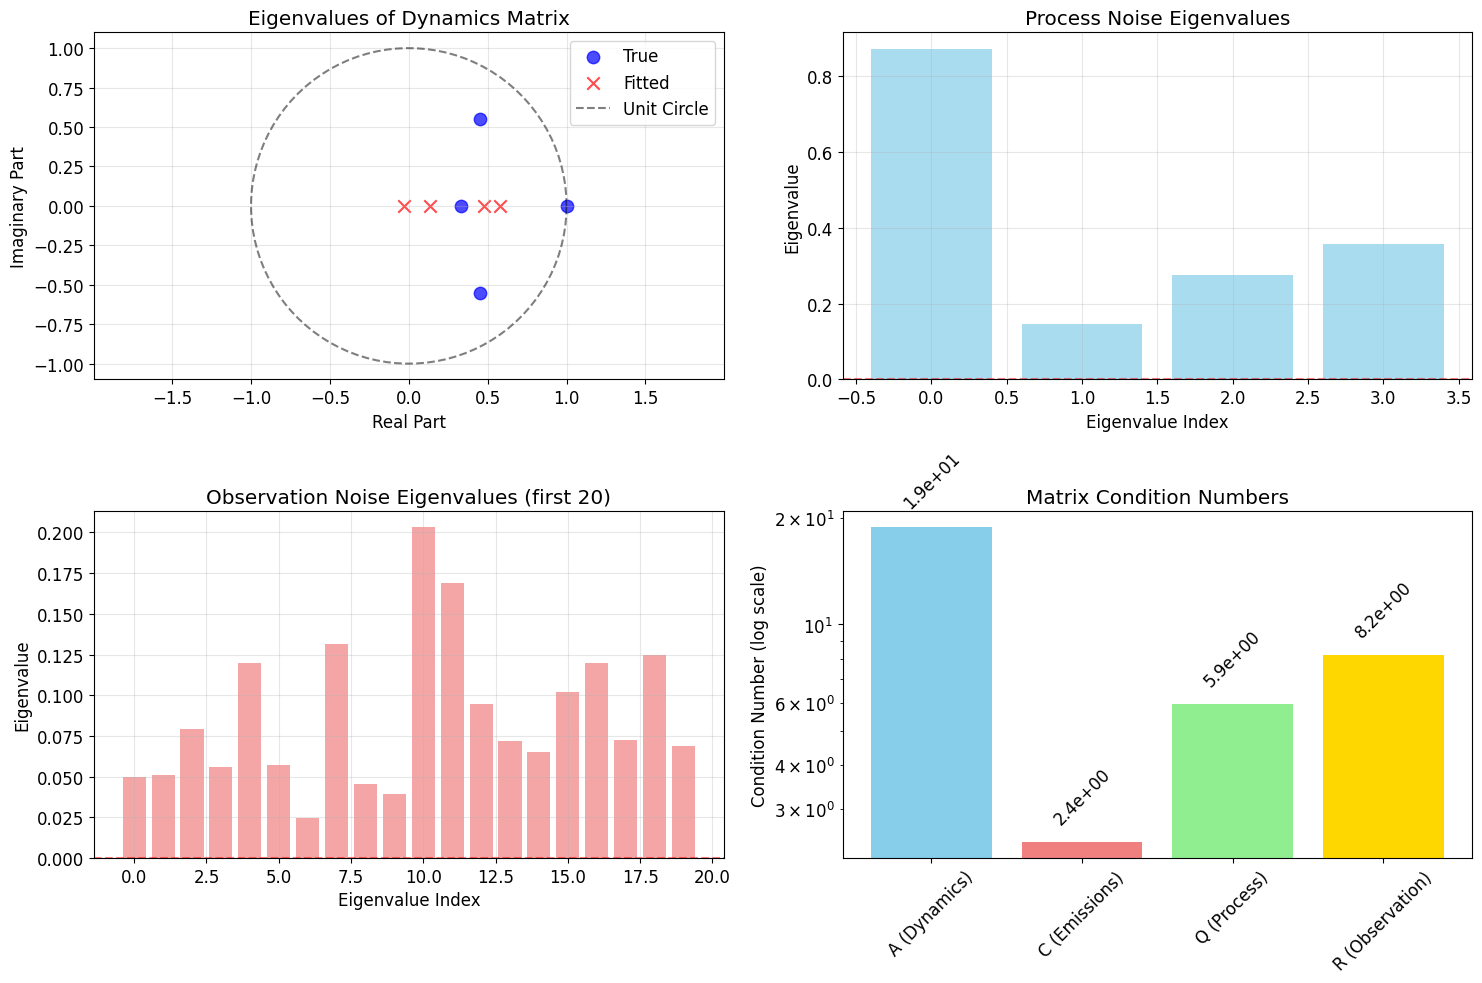

✅ Numerical stability visualization created


In [13]:
# Create stability visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Eigenvalue plot for dynamics
eigenvals_true = jnp.linalg.eigvals(A_true)
eigenvals_fitted = jnp.linalg.eigvals(A_fitted)

# Plot in complex plane
axes[0, 0].scatter(jnp.real(eigenvals_true), jnp.imag(eigenvals_true), 
                  c='blue', s=80, label='True', alpha=0.7, marker='o')
axes[0, 0].scatter(jnp.real(eigenvals_fitted), jnp.imag(eigenvals_fitted), 
                  c='red', s=80, label='Fitted', alpha=0.7, marker='x')

# Draw unit circle
theta = jnp.linspace(0, 2*jnp.pi, 100)
axes[0, 0].plot(jnp.cos(theta), jnp.sin(theta), 'k--', alpha=0.5, label='Unit Circle')
axes[0, 0].set_xlabel('Real Part')
axes[0, 0].set_ylabel('Imaginary Part')
axes[0, 0].set_title('Eigenvalues of Dynamics Matrix')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axis('equal')

# 2. Covariance eigenvalues
Q_eigenvals = jnp.linalg.eigvals(Q_fitted)
R_eigenvals = jnp.linalg.eigvals(R_fitted)

axes[0, 1].bar(range(len(Q_eigenvals)), Q_eigenvals, alpha=0.7, label='Q (Process)', color='skyblue')
axes[0, 1].set_xlabel('Eigenvalue Index')
axes[0, 1].set_ylabel('Eigenvalue')
axes[0, 1].set_title('Process Noise Eigenvalues')
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].grid(True, alpha=0.3)

# 3. Observation noise eigenvalues (show subset)
n_show = min(20, len(R_eigenvals))
axes[1, 0].bar(range(n_show), R_eigenvals[:n_show], alpha=0.7, color='lightcoral')
axes[1, 0].set_xlabel('Eigenvalue Index')
axes[1, 0].set_ylabel('Eigenvalue')
axes[1, 0].set_title(f'Observation Noise Eigenvalues (first {n_show})')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

# 4. Condition numbers
matrices = ['A (Dynamics)', 'C (Emissions)', 'Q (Process)', 'R (Observation)']
condition_numbers = [
    jnp.linalg.cond(A_fitted),
    jnp.linalg.cond(params_fitted.emissions.weights),
    jnp.linalg.cond(Q_fitted),
    jnp.linalg.cond(R_fitted)
]

bars = axes[1, 1].bar(matrices, condition_numbers, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
axes[1, 1].set_ylabel('Condition Number (log scale)')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Matrix Condition Numbers')
axes[1, 1].tick_params(axis='x', rotation=45)

# Add value labels
for bar, value in zip(bars, condition_numbers):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1,
                   f'{value:.1e}', ha='center', va='bottom', rotation=45)

plt.tight_layout()
plt.show()

print("✅ Numerical stability visualization created")

## 8. Validation Metrics and Forecasting Performance

We evaluate the fitted model's predictive capabilities using held-out data through:

1. **One-step ahead predictions** - How well can the model predict the next time step?
2. **Multi-step forecasting** - How does prediction accuracy decay over longer horizons?
3. **Comparison with baselines** - Performance relative to simple forecasting methods

### 8.1 One-Step Ahead Prediction Analysis

In [14]:
# Compute one-step ahead predictions for validation data
print(" Computing one-step ahead predictions...")

def compute_one_step_predictions(model, params, observations):
    """
    Compute one-step ahead predictions using filtering
    """
    T, N = observations.shape
    predictions = jnp.zeros_like(observations)
    
    # Get filtered posterior
    posterior = model.filter(params, observations)
    filtered_means = posterior[0] # (T, D)
    
    # One-step predictions: y_{t+1|t} = C * x_{t+1|t} = C * A * x_{t|t}
    A = params.dynamics.weights
    C = params.emissions.weights
    
    for t in range(T-1):
        # Predict next latent state: x_{t+1|t} = A * x_{t|t}
        x_pred = A @ filtered_means[t]
        # Predict next observation: y_{t+1|t} = C * x_{t+1|t}
        predictions = predictions.at[t+1].set(C @ x_pred)
    
    return predictions

# Compute predictions on test data
test_predictions = compute_one_step_predictions(ctds, params_fitted, test_obs)

# Compute prediction errors
prediction_errors = test_predictions[1:] - test_obs[1:]  # Skip first time point
prediction_errors_flat = prediction_errors.flatten()

# RMSE and NRMSE metrics
rmse_per_neuron = jnp.sqrt(jnp.mean(prediction_errors**2, axis=0))
rmse_overall = jnp.sqrt(jnp.mean(prediction_errors**2))

# Normalized RMSE (by standard deviation of each channel)
test_obs_std = jnp.std(test_obs, axis=0)
nrmse_per_neuron = rmse_per_neuron / test_obs_std
nrmse_overall = jnp.mean(nrmse_per_neuron)

# Mean Absolute Error
mae_per_neuron = jnp.mean(jnp.abs(prediction_errors), axis=0)
mae_overall = jnp.mean(mae_per_neuron)

print(f"✅ One-step ahead prediction metrics:")
print(f"  Overall RMSE:     {rmse_overall:.4f}")
print(f"  Overall NRMSE:    {nrmse_overall:.4f}")
print(f"  Overall MAE:      {mae_overall:.4f}")
print(f"  RMSE range:       [{jnp.min(rmse_per_neuron):.4f}, {jnp.max(rmse_per_neuron):.4f}]")
print(f"  NRMSE range:      [{jnp.min(nrmse_per_neuron):.4f}, {jnp.max(nrmse_per_neuron):.4f}]")

# R² for predictions
pred_r2_per_neuron = jnp.array([
    compute_r_squared(test_obs[1:, i], test_predictions[1:, i])
    for i in range(N)
])
pred_r2_overall = jnp.mean(pred_r2_per_neuron)

print(f"  Prediction R²:    {pred_r2_overall:.4f}")
print(f"  R² range:         [{jnp.min(pred_r2_per_neuron):.4f}, {jnp.max(pred_r2_per_neuron):.4f}]")

 Computing one-step ahead predictions...
✅ One-step ahead prediction metrics:
  Overall RMSE:     0.0648
  Overall NRMSE:    1.0048
  Overall MAE:      0.0511
  RMSE range:       [0.0494, 0.1039]
  NRMSE range:      [0.9019, 1.0917]
  Prediction R²:    -0.0110
  R² range:         [-0.1860, 0.1888]


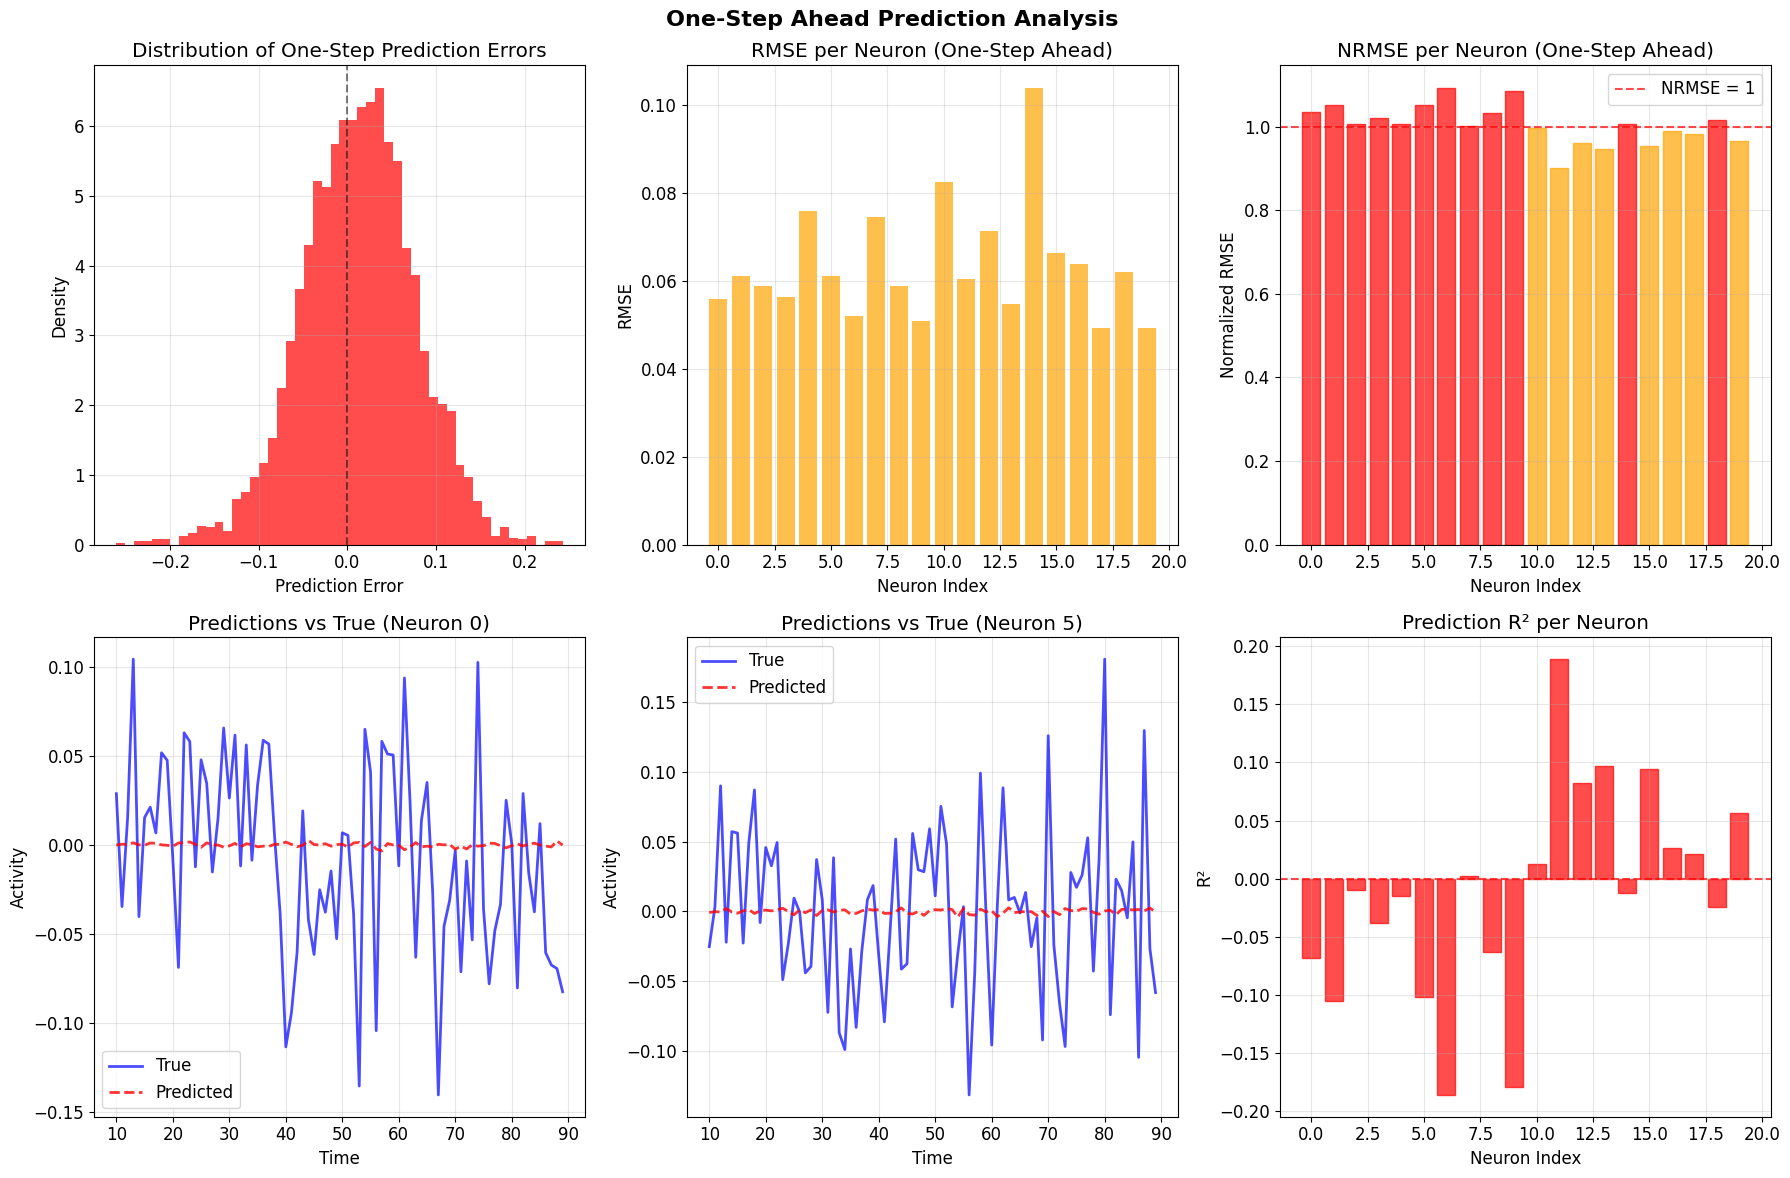


📊 One-Step Ahead Prediction Summary:
  Neurons with NRMSE < 0.5: 0/20 (0.0%)
  Neurons with R² > 0.5:    0/20 (0.0%)
  Neurons with R² > 0.8:    0/20 (0.0%)


In [15]:
# Visualize one-step ahead prediction performance
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Prediction errors histogram
axes[0, 0].hist(prediction_errors_flat, bins=50, alpha=0.7, color='red', density=True)
axes[0, 0].set_xlabel('Prediction Error')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Distribution of One-Step Prediction Errors')
axes[0, 0].axvline(0, color='black', linestyle='--', alpha=0.5)
axes[0, 0].grid(True, alpha=0.3)

# 2. RMSE per neuron
neuron_indices = jnp.arange(N)
axes[0, 1].bar(neuron_indices, rmse_per_neuron, alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Neuron Index')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('RMSE per Neuron (One-Step Ahead)')
axes[0, 1].grid(True, alpha=0.3)

# 3. NRMSE per neuron
bars = axes[0, 2].bar(neuron_indices, nrmse_per_neuron, alpha=0.7, color='purple')
axes[0, 2].set_xlabel('Neuron Index')
axes[0, 2].set_ylabel('Normalized RMSE')
axes[0, 2].set_title('NRMSE per Neuron (One-Step Ahead)')
axes[0, 2].axhline(1.0, color='red', linestyle='--', alpha=0.7, label='NRMSE = 1')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Color bars by performance (green = good, red = poor)
for i, bar in enumerate(bars):
    if nrmse_per_neuron[i] < 0.5:
        bar.set_color('green')
    elif nrmse_per_neuron[i] < 1.0:
        bar.set_color('orange')
    else:
        bar.set_color('red')


# 4. Sample time traces of predictions vs observations
sample_neurons = [0, N//4, N//2, 3*N//4] if N >= 4 else [0, min(1, N-1)]
time_window = slice(10, min(90, T))  # Ensure we don't exceed data length

for i, neuron_idx in enumerate(sample_neurons[:2]):
    if i >= 2:
        break
    ax = axes[1, i]
    
    # Create time range that matches the actual data slice
    data_slice = test_obs[time_window, neuron_idx]
    pred_slice = test_predictions[time_window, neuron_idx]
    t_range = jnp.arange(time_window.start, time_window.start + len(data_slice))
    
    ax.plot(t_range, data_slice, 'b-', alpha=0.7, 
            label='True', linewidth=2)
    ax.plot(t_range, pred_slice, 'r--', alpha=0.8, 
            label='Predicted', linewidth=2)
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Activity')
    ax.set_title(f'Predictions vs True (Neuron {neuron_idx})')
    ax.legend()
    ax.grid(True, alpha=0.3)


# 5. Prediction R² per neuron
bars_r2 = axes[1, 2].bar(neuron_indices, pred_r2_per_neuron, alpha=0.7)
axes[1, 2].set_xlabel('Neuron Index')
axes[1, 2].set_ylabel('R²')
axes[1, 2].set_title('Prediction R² per Neuron')
axes[1, 2].axhline(0.0, color='red', linestyle='--', alpha=0.7)
axes[1, 2].grid(True, alpha=0.3)

# Color R² bars by performance
for i, bar in enumerate(bars_r2):
    if pred_r2_per_neuron[i] > 0.8:
        bar.set_color('darkgreen')
    elif pred_r2_per_neuron[i] > 0.5:
        bar.set_color('green')
    elif pred_r2_per_neuron[i] > 0.2:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.suptitle('One-Step Ahead Prediction Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📊 One-Step Ahead Prediction Summary:")
print(f"  Neurons with NRMSE < 0.5: {jnp.sum(nrmse_per_neuron < 0.5)}/{N} ({100*jnp.mean(nrmse_per_neuron < 0.5):.1f}%)")
print(f"  Neurons with R² > 0.5:    {jnp.sum(pred_r2_per_neuron > 0.5)}/{N} ({100*jnp.mean(pred_r2_per_neuron > 0.5):.1f}%)")
print(f"  Neurons with R² > 0.8:    {jnp.sum(pred_r2_per_neuron > 0.8)}/{N} ({100*jnp.mean(pred_r2_per_neuron > 0.8):.1f}%)")